### 1. 데이터셋 및 전처리

-   **데이터셋 구성**
    -   웹 스크레이핑을 통해 수집한 자체 데이터셋을 사용할 예정.
    -   클래스는 **Street, Minimal, Amekaji, Feminine** 총 4개.
    -   데이터는 클래스당 100장의 Full body 이미지, 총 400장으로 구성됨.

-   **전처리 및 데이터 증강 계획**
    -   모든 이미지는 사전 훈련 모델의 입력 크기인 `(224, 224)`로 표준화할 것.
    -   픽셀 값은 `[0, 1]` 범위로 정규화하여 학습 안정성을 확보할 예정.
    -   훈련 데이터에 한해 `ImageDataGenerator`를 활용, Data Augmentation을 적용하여 모델의 과적합을 방지하고 일반화 성능을 향상.

In [26]:
# === 1) 데이터셋 및 전처리 ===
import math, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR    = '../image'
IMAGE_SIZE  = (224, 224)
BATCH_SIZE  = 32
VAL_SPLIT   = 0.20
SEED        = 42

# (A) 문서 기준: 폴더명이 amekaji/feminine/minimal/street 인 경우
# CLASS_NAMES = ['amekaji','feminine','minimal','street']

# (B) 리포 기준: 폴더명이 amekaji/casual/minimal/street 인 경우
CLASS_NAMES = ['amekaji','casual','minimal','street']

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest',
    validation_split=VAL_SPLIT
)

train_gen = datagen.flow_from_directory(
    DATA_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    classes=CLASS_NAMES, class_mode='categorical',
    subset='training', shuffle=True, seed=SEED, color_mode='rgb'
)

valid_gen = datagen.flow_from_directory(
    DATA_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    classes=CLASS_NAMES, class_mode='categorical',
    subset='validation', shuffle=False, seed=SEED, color_mode='rgb'
)

steps_per_epoch  = max(1, math.ceil(train_gen.samples / BATCH_SIZE))
validation_steps = max(1, math.ceil(valid_gen.samples / BATCH_SIZE))

print("class_indices:", train_gen.class_indices)
print("samples(train, valid):", train_gen.samples, valid_gen.samples)

# 검증 분포 체크(각 클래스 최소 1장 확인)
vals, cnts = np.unique(valid_gen.classes, return_counts=True)
dist = {CLASS_NAMES[v]: int(c) for v,c in zip(vals, cnts)}
print("valid distribution:", dist)
missing = [CLASS_NAMES[i] for i in range(len(CLASS_NAMES)) if i not in vals]
if missing: print("⚠️ 검증셋에 전혀 없는 클래스:", missing)


Found 420 images belonging to 4 classes.
Found 104 images belonging to 4 classes.
class_indices: {'amekaji': 0, 'casual': 1, 'minimal': 2, 'street': 3}
samples(train, valid): 420 104
valid distribution: {'amekaji': 20, 'casual': 21, 'minimal': 20, 'street': 43}


### 2. 모델 아키텍처 및 훈련

-   **모델 아키텍처 선정**
    -   전이 학습의 효과와 아키텍처별 성능 비교를 위해 **VGG16**과 **ResNet50**을 각각 베이스라인 및 비교 모델로 사용.
    -   두 모델 모두 ImageNet으로 사전 훈련된 **합성곱 베이스(Convolutional Base)의 가중치는 동결(Freeze)**하여 사용될 예정.

-   **미세조정(Fine-tuning) 설계**
    -   동결된 베이스 모델 위에 Classifier Head를 추가할 계획.
    -   분류기는 `GlobalAveragePooling2D`, `Dropout(0.5)`, `Dense(1024, 'relu')`, 그리고 최종 `Dense(4, 'softmax')` 층으로 구성됨. `Dropout`을 통해 과적합을 억제할 예정.

-   **훈련 계획**
    -   옵티마이저는 `Adam`, 손실 함수는 `categorical_crossentropy`를 사용할 것.
    -   훈련은 초기 20 에포크(Epoch) 동안 진행하며, 학습 곡선(정확도 및 손실)을 시각화하여 과적합 여부를 검토할 예정.



=== Training: VGG16 ===


/Users/jihohan/miniforge3/envs/kcu5-tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.3381 - loss: 1.3880 - val_accuracy: 0.4135 - val_loss: 1.3099
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 0.3833 - loss: 1.3397 - val_accuracy: 0.4135 - val_loss: 1.2868
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - accuracy: 0.4262 - loss: 1.2928 - val_accuracy: 0.4135 - val_loss: 1.2531
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.4333 - loss: 1.3017 - val_accuracy: 0.4231 - val_loss: 1.2262
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 353ms/step - accuracy: 0.4452 - loss: 1.2529 - val_accuracy: 0.4231 - val_loss: 1.2078
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.4619 - loss: 1.2206 - val_accuracy: 0.4231 - val_loss: 1.1943
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 353ms/step - accuracy: 0.4476 - loss: 1.2079 - val_accuracy: 0.4327 - val_loss: 1.1555
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.4976 - loss: 1.1836 - val_accuracy: 0.

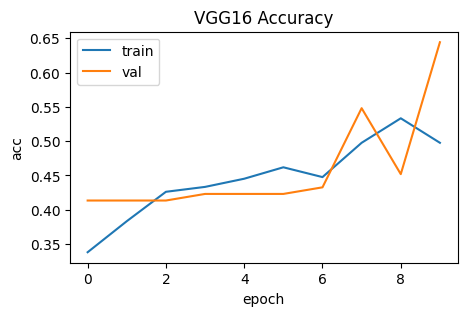


=== Training: RESNET50 ===
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step - accuracy: 0.3000 - loss: 1.7948 - val_accuracy: 0.4135 - val_loss: 1.3499
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.3310 - loss: 1.5544 - val_accuracy: 0.4135 - val_loss: 1.3145
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.2929 - loss: 1.4470 - val_accuracy: 0.4423 - val_loss: 1.2733
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.4190 - loss: 1.3531 - val_accuracy: 0.4519 - val_loss: 1.2488
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - accuracy: 0.4405 - loss: 1.2829 - val_accuracy: 0.4904 - val_loss: 1.2242
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - accuracy: 0.4286 - loss: 1.3061 - val_accuracy: 0.4519 - val_loss: 1.2145
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.4000 - loss: 1.2962 - val_accuracy: 0.5000 - val_loss: 1.2138
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.4571 - los

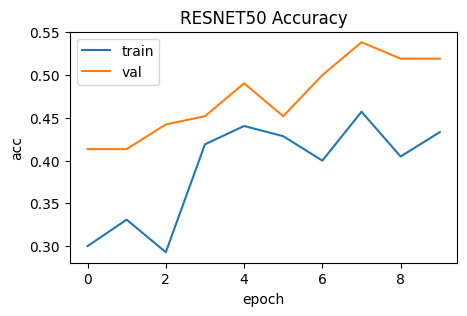

In [27]:
# === 2. 모델 아키텍처 & 훈련 (간단 버전) ===
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50

NUM_CLASSES = len(CLASS_NAMES)

def build_model(arch='vgg16', input_shape=(224,224,3), num_classes=4, freeze_base=True):
    if arch == 'vgg16':
        base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    elif arch == 'resnet50':
        base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError("arch는 'vgg16' 또는 'resnet50'만 허용")

    base.trainable = not freeze_base  # 간단: 기본은 동결(True)
    x = layers.Input(shape=input_shape)
    y = base(x, training=False)
    y = layers.GlobalAveragePooling2D()(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(1024, activation='relu')(y)
    out = layers.Dense(num_classes, activation='softmax')(y)
    model = models.Model(x, out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_once(arch, epochs=10):
    print(f"\n=== Training: {arch.upper()} ===")
    model = build_model(arch=arch, input_shape=(*IMAGE_SIZE,3), num_classes=NUM_CLASSES, freeze_base=True)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    hist = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_gen,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=[es],
        verbose=1
    )
    # 간단 평가
    val_loss, val_acc = model.evaluate(valid_gen, steps=validation_steps, verbose=0)
    print(f"[{arch.upper()}] Val Acc = {val_acc:.4f}")

    # 학습곡선 간단 플롯(정확도만)
    plt.figure(figsize=(5,3))
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='val')
    plt.title(f'{arch.upper()} Accuracy')
    plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend(); plt.show()
    return model, hist

# VGG16 먼저 간단 학습
vgg_model, vgg_hist = train_once('vgg16', epochs=10)

# 이어서 ResNet50 간단 학습
res_model, res_hist = train_once('resnet50', epochs=10)

### 3. 모델 성능 평가

- **정량적 평가**
    - 검증 데이터셋을 통해 훈련된 각 모델의 최종 성능을 정량적으로 평가.
    - **평가 지표:** Accuracy, Precision, Recall, F1-Score를 핵심 지표로 사용.

- **결과 제시**
    - VGG16과 ResNet50 모델의 최종 성능을 비교 제시하여 아키텍처별 효율성을 분석.
    - Confusion Matrix을 시각화하여, 모델이 어떤 클래스 간에 혼동을 보이는지 분석.


[VGG16] Validation Accuracy: 0.4231

              precision    recall  f1-score   support

     amekaji     0.0000    0.0000    0.0000        20
      casual     0.5000    0.0952    0.1600        21
     minimal     0.0000    0.0000    0.0000        20
      street     0.4200    0.9767    0.5874        43

    accuracy                         0.4231       104
   macro avg     0.2300    0.2680    0.1869       104
weighted avg     0.2746    0.4231    0.2752       104

Validation class counts:
  amekaji: 20
  casual: 21
  minimal: 20
  street: 43


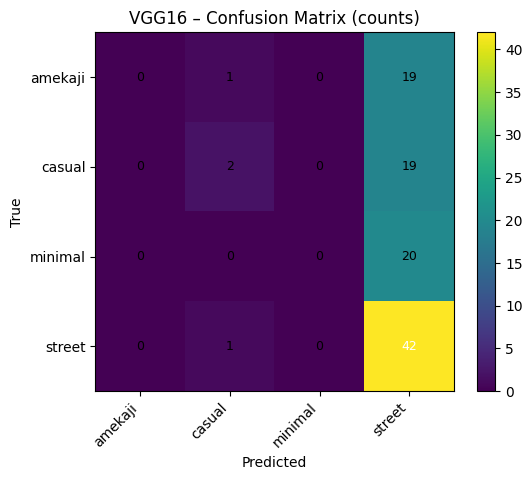

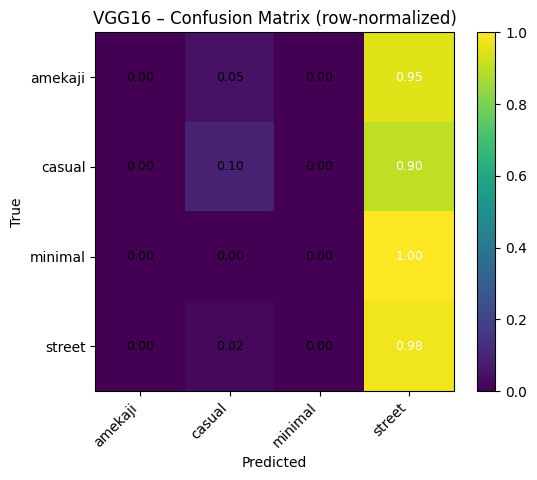


[ResNet50] Validation Accuracy: 0.5385

              precision    recall  f1-score   support

     amekaji     0.0000    0.0000    0.0000        20
      casual     0.0000    0.0000    0.0000        21
     minimal     0.5185    0.7000    0.5957        20
      street     0.5455    0.9767    0.7000        43

    accuracy                         0.5385       104
   macro avg     0.2660    0.4192    0.3239       104
weighted avg     0.3252    0.5385    0.4040       104

Validation class counts:
  amekaji: 20
  casual: 21
  minimal: 20
  street: 43


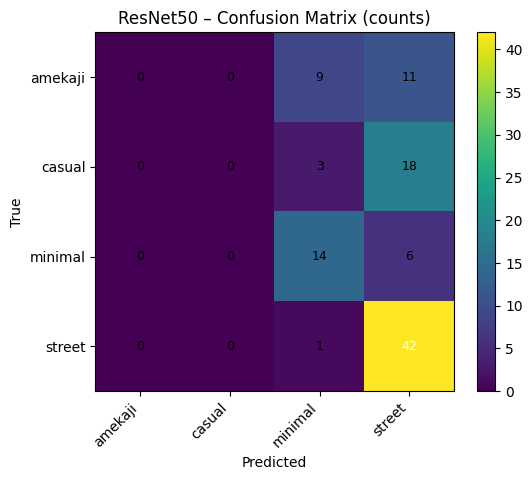

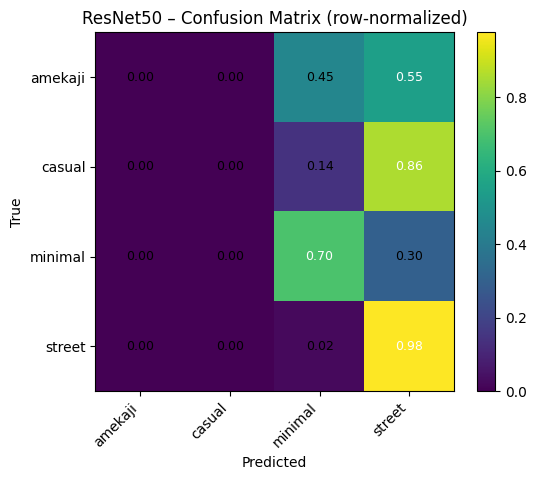

In [25]:
# === 3) 모델 성능 평가 ===
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

NUM_CLASSES  = len(CLASS_NAMES)
FIXED_LABELS = list(range(NUM_CLASSES))
TARGET_NAMES = CLASS_NAMES[:]

def evaluate_model(model, gen, name="model"):
    gen.reset()
    probs  = model.predict(gen, verbose=0)
    y_pred = probs.argmax(axis=1)
    y_true = gen.classes

    acc = accuracy_score(y_true, y_pred)
    print(f"\n[{name}] Validation Accuracy: {acc:.4f}\n")

    print(classification_report(
        y_true, y_pred,
        labels=FIXED_LABELS,
        target_names=TARGET_NAMES,
        digits=4,
        zero_division=0
    ))

    unique, counts = np.unique(y_true, return_counts=True)
    print("Validation class counts:")
    for i in FIXED_LABELS:
        c = counts[unique.tolist().index(i)] if i in unique else 0
        print(f"  {TARGET_NAMES[i]}: {c}")

    cm = confusion_matrix(y_true, y_pred, labels=FIXED_LABELS).astype(np.int64)
    with np.errstate(invalid='ignore', divide='ignore'):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0)

    def plot_cm(cm_, title):
        plt.figure(figsize=(5.8, 4.8))
        plt.imshow(cm_, interpolation='nearest')
        plt.title(title); plt.colorbar()
        tick = np.arange(NUM_CLASSES)
        plt.xticks(tick, TARGET_NAMES, rotation=45, ha='right')
        plt.yticks(tick, TARGET_NAMES)
        vmax = np.nanmax(cm_)
        thresh = (vmax/2) if np.isfinite(vmax) and vmax>0 else 0.5
        for i in range(cm_.shape[0]):
            for j in range(cm_.shape[1]):
                val = cm_[i, j]
                txt = f"{val:.2f}" if np.issubdtype(cm_.dtype, np.floating) else f"{val}"
                plt.text(j, i, txt, ha='center', va='center',
                         color='white' if val > thresh else 'black', fontsize=9)
        plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

    plot_cm(cm,      f"{name} – Confusion Matrix (counts)")
    plot_cm(cm_norm, f"{name} – Confusion Matrix (row-normalized)")

# 사용 예시
evaluate_model(vgg_model, valid_gen, name="VGG16")
evaluate_model(res_model, valid_gen, name="ResNet50")


### 4. 모델 해석 및 정성적 분석

- **정성적 분석**
    - 모델의 의사결정 과정을 시각적으로 해석하기 위해 정성적 분석을 수행.
    - **분석 기법:** Grad-CAM을 사용하여 예측의 근거가 되는 이미지 내 Attention을 시각화.

- **결과 제시**
    - 각 스타일별 예측에 대한 Grad-CAM 히트맵 예시를 제시.

- **분석 목표**
    - 시각화 결과를 통해 모델이 단순히 데이터의 패턴을 암기한 것이 아니라, 각 스타일을 정의하는 유의미한 Semantic 특징을 학습했는지 확인할 계획.